### Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Read and preprocess the data

In [33]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data_Corrected/10k_data_cleaned.csv')

In [34]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

In [35]:
df_mp.head()

,Unnamed: 0.1,Unnamed: 0,nsites,composition,formula_pretty,volume,symmetry,material_id,structure,formation_energy_per_atom,...,mean ordering parameter shell 3,max packing efficiency,structural complexity per atom,structural complexity per cell,spacegroup_num,crystal_system,crystal_system_int,is_centrosymmetric,n_symmetry_ops,dimensionality
2,1814,1814,3,Kr1 F2,KrF2,54.722214,"{'crystal_system': 'Tetragonal', 'symbol': 'I4...",mp-30009,"{'@module': 'pymatgen.core.structure', '@class...",-0.009234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,5165,5165,2,Ge1 Te1,GeTe,55.908969,"{'crystal_system': 'Trigonal', 'symbol': 'R3m'...",mp-938,"{'@module': 'pymatgen.core.structure', '@class...",-0.035468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,5174,5174,36,Ga1 I2,GaI2,1479.441332,"{'crystal_system': 'Trigonal', 'symbol': 'R3c'...",mp-570738,"{'@module': 'pymatgen.core.structure', '@class...",-0.727731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,1800,1800,3,Sr1 O2,SrO2,41.984217,"{'crystal_system': 'Tetragonal', 'symbol': 'I4...",mp-2697,"{'@module': 'pymatgen.core.structure', '@class...",-2.204479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,1802,1802,5,Sn1 F4,SnF4,64.612040,"{'crystal_system': 'Tetragonal', 'symbol': 'I4...",mp-2706,"{'@module': 'pymatgen.core.structure', '@class...",-2.571480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train-test split

In [36]:

# Step 1: Define and clean inputs
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

#
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

# Step 4: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Feature selection AFTER scaling
#X_selected = SelectKBest(score_func=f_regression, k=30).fit_transform(X_scaled, y)

# Step 6: Train-test split on selected features and aligned y
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, original_indices, test_size=0.2, random_state=42
)


In [37]:


# Store the selector
selector = SelectKBest(score_func=f_regression, k=100)
X_scaled_selected = selector.fit_transform(X, y)

mask = selector.get_support()                # boolean mask of selected features
selected_indices = selector.get_support(indices=True)  # or integer indices

selected_feature_names = X.columns[mask].tolist()
print(selected_feature_names)


['volume', 'formation_energy_per_atom', 'H', 'Be', 'F', 'Mg', 'P', 'Cl', 'Se', 'Te', 'transition metal fraction', 'band center', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData mean Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData mean MeltingT', 'MagpieData mode MeltingT', 'MagpieData maximum Column', 'MagpieData minimum Row', 'MagpieData maximum Row', 'MagpieData mean Row', 'MagpieData mode Row', 'MagpieData minimum CovalentRadius', 'MagpieData maximum CovalentRadius', 'MagpieData mean CovalentRadius', 'MagpieData mode CovalentRadius', 'MagpieData maximum Electronegativity', 'MagpieData range Electronegativity', 'MagpieData mean Electronegativity', 'MagpieDat

In [38]:
scores = selector.scores_
pvalues = selector.pvalues_

score_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores,
    'P-value': pvalues
})

top_k = score_df.sort_values(by='Score', ascending=False).head(30)

print(top_k)


                                  Feature       Score       P-value
399                           HOMO_energy  232.335499  6.124466e-47
171        MagpieData mean CovalentRadius  210.978386  3.469762e-43
388                     mean AtomicRadius  209.657258  5.954560e-43
168     MagpieData minimum CovalentRadius  195.142019  2.347249e-40
173        MagpieData mode CovalentRadius  192.674520  6.535317e-40
175  MagpieData maximum Electronegativity  187.533336  5.560515e-39
4               formation_energy_per_atom  184.864782  1.696342e-38
396              frac p valence electrons  169.026260  1.347917e-35
390                mean Electronegativity  165.191813  6.892102e-35
177     MagpieData mean Electronegativity  165.191813  6.892102e-35
384                              mean Row  159.538522  7.726185e-34
165                   MagpieData mean Row  159.538522  7.726185e-34
401                                gap_AO  147.608739  1.323852e-31
249             MagpieData mean GSbandgap  144.9

In [39]:
print(X_scaled_selected)

[[ 5.47222140e+01 -9.23435222e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.59089688e+01 -3.54679950e-02  0.00000000e+00 ...  0.00000000e+00
   1.81309431e-02  9.45528683e-02]
 [ 1.47944133e+03 -7.27731254e-01  0.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 ...
 [ 7.57983453e+03  2.18891502e+00  0.00000000e+00 ...  4.15945165e-02
   1.37072839e-01  1.92238091e-01]
 [ 3.34132997e+03  1.14763830e+00  0.00000000e+00 ...  2.17571317e-02
   3.72928614e-02  1.34334291e-01]
 [ 4.42959443e+03  2.76805892e+00  0.00000000e+00 ...  9.42809042e-02
   1.48155707e-01  1.97989899e-01]]


In [40]:
# Normalise training data
#scaler_x = StandardScaler()
#scaler_y = StandardScaler()


#X_train = scaler_x.fit_transform(X_train_raw) #computes mean and std from training data and scales it
#X_test = scaler_x.transform(X_test_raw) #uses the same mean and std to scale test data


#y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
#y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel() #ravel() flattens the output back to 1D, which is typically needed for PyTorch models expecting targets as flat vectors.

#scaler_x = StandardScaler()
#X_train = scaler_x.fit_transform(X_train)
#X_test = scaler_x.transform(X_test)

## Run Gaussian Process Regression 

In [41]:
kernel = (
    ConstantKernel(1.0, (1e-3, 1e6)) *
    (RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e6)) +
     Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-5, 1e6)) +
     RationalQuadratic(length_scale=1.0, alpha=1.0, alpha_bounds=(1e-5, 1e7)))
    + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-12, 10))
)
#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-3)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30, normalize_y=True)
gpr.fit(X_train, y_train)

# Predict with uncertainty
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Evaluate
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

print("Optimized kernel:", gpr.kernel_)

R² score: 0.5328906486796023
RMSE: 0.9748952991026086
Optimized kernel: 1.03**2 * RBF(length_scale=21.9) + Matern(length_scale=3.43e+04, nu=2.5) + RationalQuadratic(alpha=0.0651, length_scale=2.3) + WhiteKernel(noise_level=2.68e-10)


In [42]:
pipe = Pipeline([
    ('select', SelectKBest(score_func=f_regression)),
    ('gpr', GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True))
])

param_grid = {
    'select__k': [20, 30, 50, 100, 120, 137],  # 137 is the max
    'gpr__alpha': [1e-10, 1e-8, 1e-6]
}

search = GridSearchCV(pipe, param_grid, cv=3, scoring='r2', n_jobs=-1)
search.fit(X_scaled, y)
print("Best R2:", search.best_score_)
print("Best params:", search.best_params_)

/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:380: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:380: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:380: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 34 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.htm

Best R2: 0.5485925124672595
Best params: {'gpr__alpha': 1e-08, 'select__k': 50}


In [43]:

scores = cross_val_score(gpr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("CV RMSE:", np.sqrt(-scores).mean())

CV RMSE: 0.9958060780824061


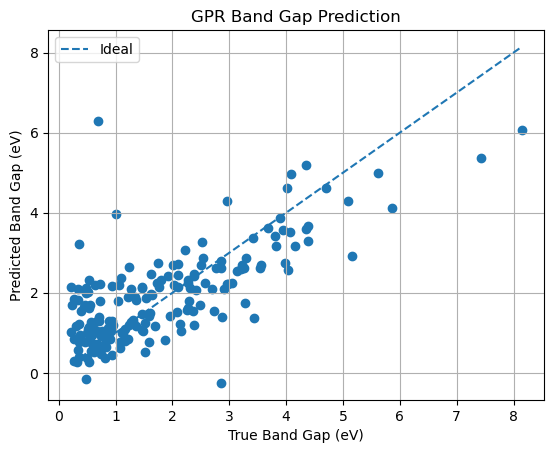

In [44]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', label='Ideal')
plt.xlabel('True Band Gap (eV)')
plt.ylabel('Predicted Band Gap (eV)')
plt.title('GPR Band Gap Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [45]:


# Get cross-validated predictions ( 5-fold)
y_pred_cv = cross_val_predict(gpr, X_train, y_train, cv=5)

# y_pred_cv = cross_val_predict(gpr, X_train, y_train, cv=5)
r2 = r2_score(y_train, y_pred_cv)
print("Cross-validated R² score:", r2)

Cross-validated R² score: 0.6324698624107185


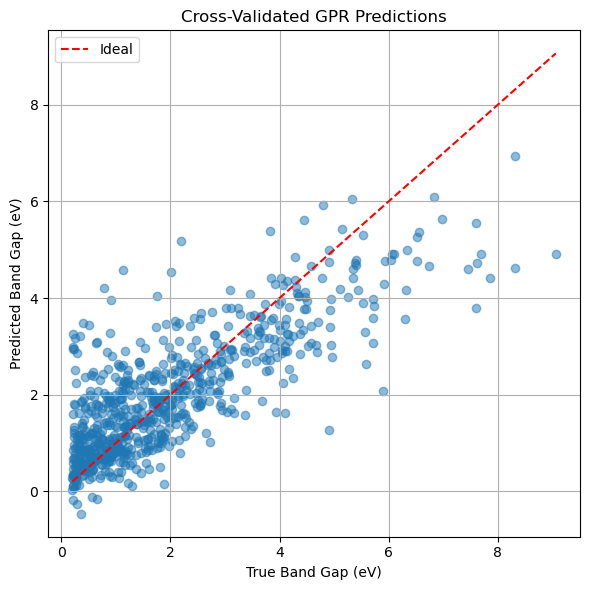

In [46]:
# Plot true vs predicted (cross-validated)
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_pred_cv, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Ideal')
plt.xlabel('True Band Gap (eV)')
plt.ylabel('Predicted Band Gap (eV)')
plt.title('Cross-Validated GPR Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

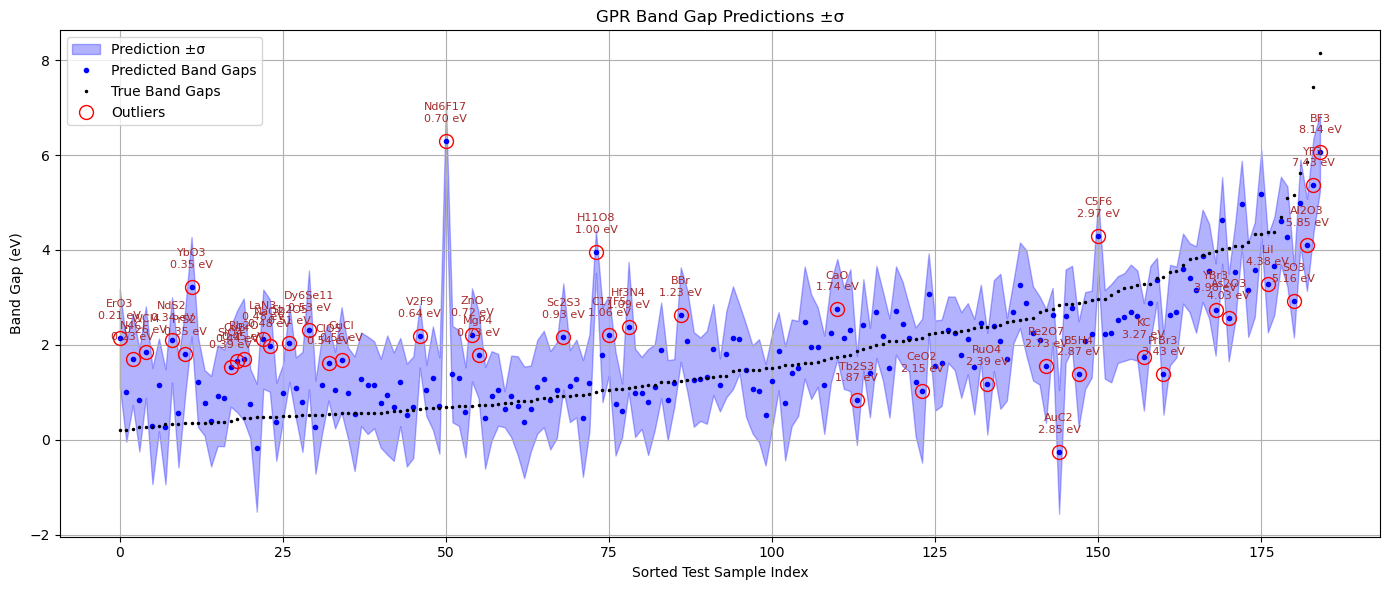

In [47]:

y_true = np.array(y_test)
y_predicted = np.array(y_pred)
y_std_dev = np.array(y_std)

# Sort by true band gap values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_predicted[sorted_idx]
y_std_sorted = y_std_dev[sorted_idx]

# 95% confidence interval
lower = y_pred_sorted -  y_std_sorted
upper = y_pred_sorted + y_std_sorted

# Optional: get formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='Prediction ±σ', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("GPR Band Gap Predictions ±σ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


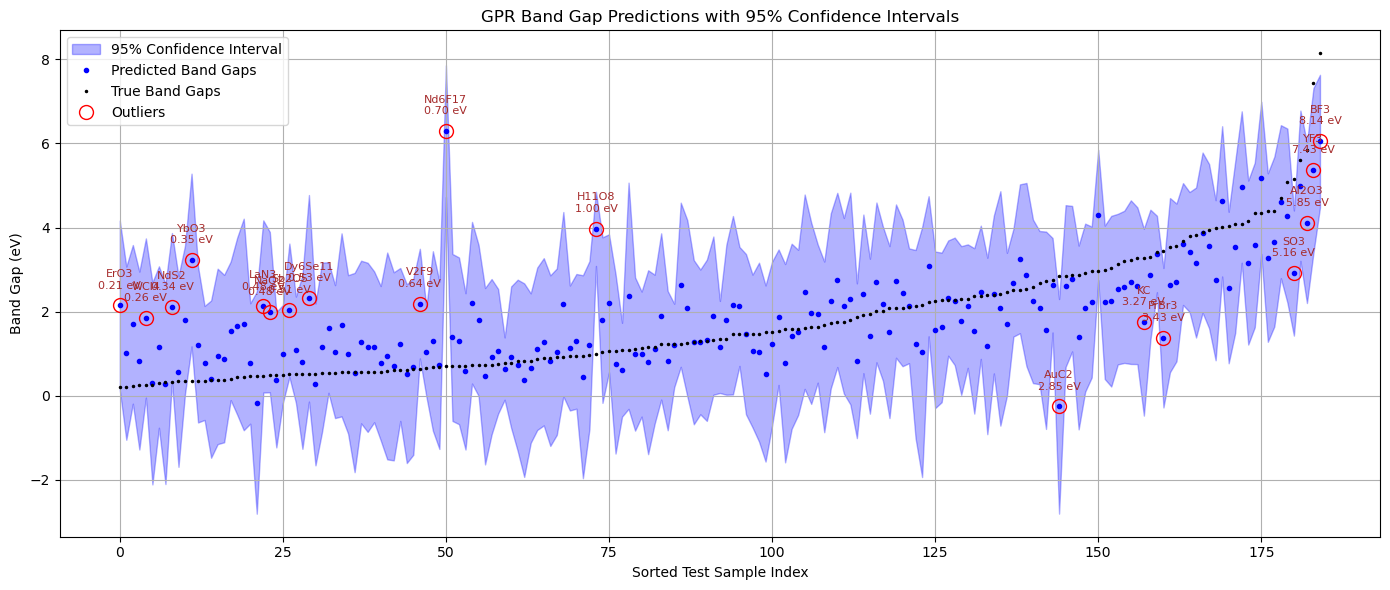

In [48]:
# Convert y_test_raw and y_pred to numpy arrays for indexing
y_true = np.array(y_test)
y_predicted = np.array(y_pred)
y_std_dev = np.array(y_std)

# Sort by true band gap values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_predicted[sorted_idx]
y_std_sorted = y_std_dev[sorted_idx]

# 95% confidence interval
lower = y_pred_sorted - 1.96 * y_std_sorted
upper = y_pred_sorted + 1.96 * y_std_sorted

# Optional: get formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='95% Confidence Interval', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("GPR Band Gap Predictions with 95% Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Log-transformed data training

In [49]:
# Before fitting
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
gpr.fit(X_train, y_train_log)
y_pred_log, y_std_log = gpr.predict(X_test, return_std=True)
y_pred = np.expm1(y_pred_log)
y_std = np.expm1(y_pred_log + y_std_log) - y_pred  # Approximate std in original space

# Step 9: Evaluate
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

print("Optimized kernel:", gpr.kernel_)

R² score: 0.5749978888986005
RMSE: 0.9299171109550647
Optimized kernel: 0.77**2 * RBF(length_scale=25.4) + Matern(length_scale=30.8, nu=2.5) + RationalQuadratic(alpha=0.173, length_scale=1.8) + WhiteKernel(noise_level=1.22e-08)


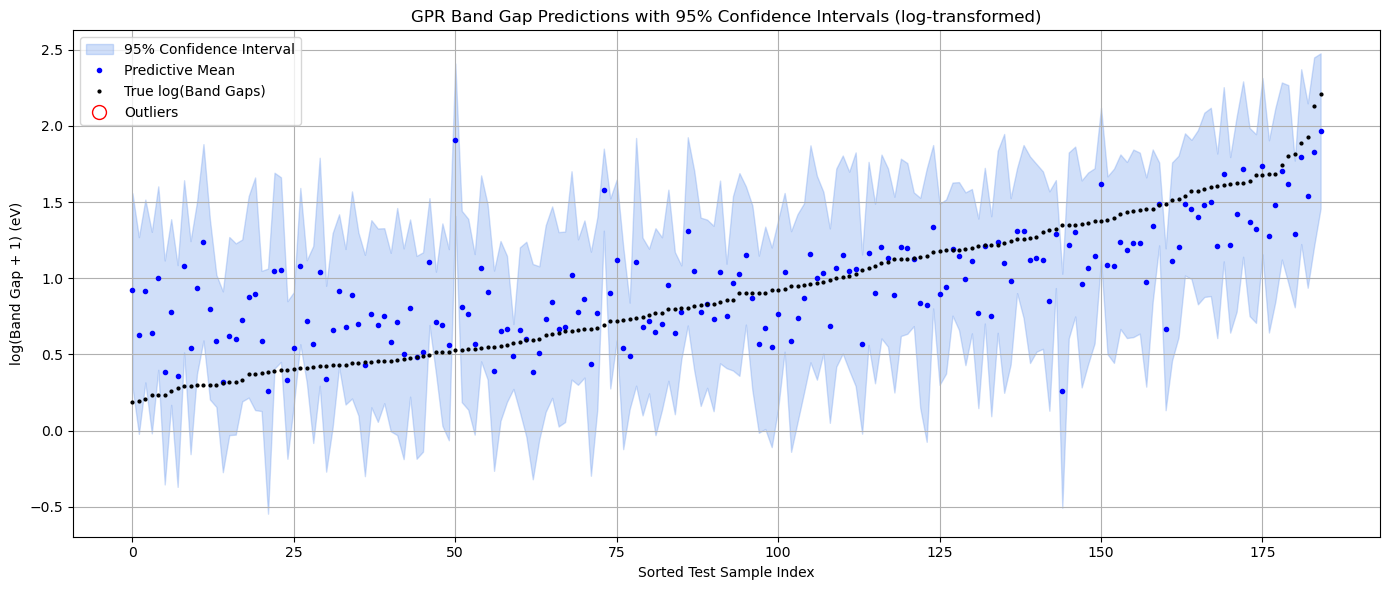

In [50]:
# Visualize log-transformed GPR predictions with 95% confidence interval

# Convert to numpy arrays
y_true_log = np.array(y_test_log)
y_pred_log = np.array(y_pred_log)
y_std_log = np.array(y_std_log)

# Sort by true log band gap values
sorted_idx = np.argsort(y_true_log)
y_true_log_sorted = y_true_log[sorted_idx]
y_pred_log_sorted = y_pred_log[sorted_idx]
y_std_log_sorted = y_std_log[sorted_idx]

# 95% confidence interval in log space
lower_log = y_pred_log_sorted - 1.96 * y_std_log_sorted
upper_log = y_pred_log_sorted + 1.96 * y_std_log_sorted

# Optional: get formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error (in log space)
errors_log = np.abs(y_true_log_sorted - y_pred_log_sorted)
outlier_mask = errors_log > 1.5  # adjust threshold as needed for log space
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_log_sorted)), lower_log, upper_log, alpha=0.3, label='95% Confidence Interval', color='cornflowerblue')

# Predicted mean
plt.plot(y_pred_log_sorted, 'o', markersize=3, label='Predictive Mean', color='blue')

# True values
plt.plot(y_true_log_sorted, 'k.', markersize=4, label='True log(Band Gaps)')

# Outliers
plt.plot(outlier_indices, y_true_log_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_true_log_sorted[i] + 0.2, f"{formulas_sorted[i]}\n{y_true_log_sorted[i]:.2f}", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("log(Band Gap + 1) (eV)")
plt.title("GPR Band Gap Predictions with 95% Confidence Intervals (log-transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

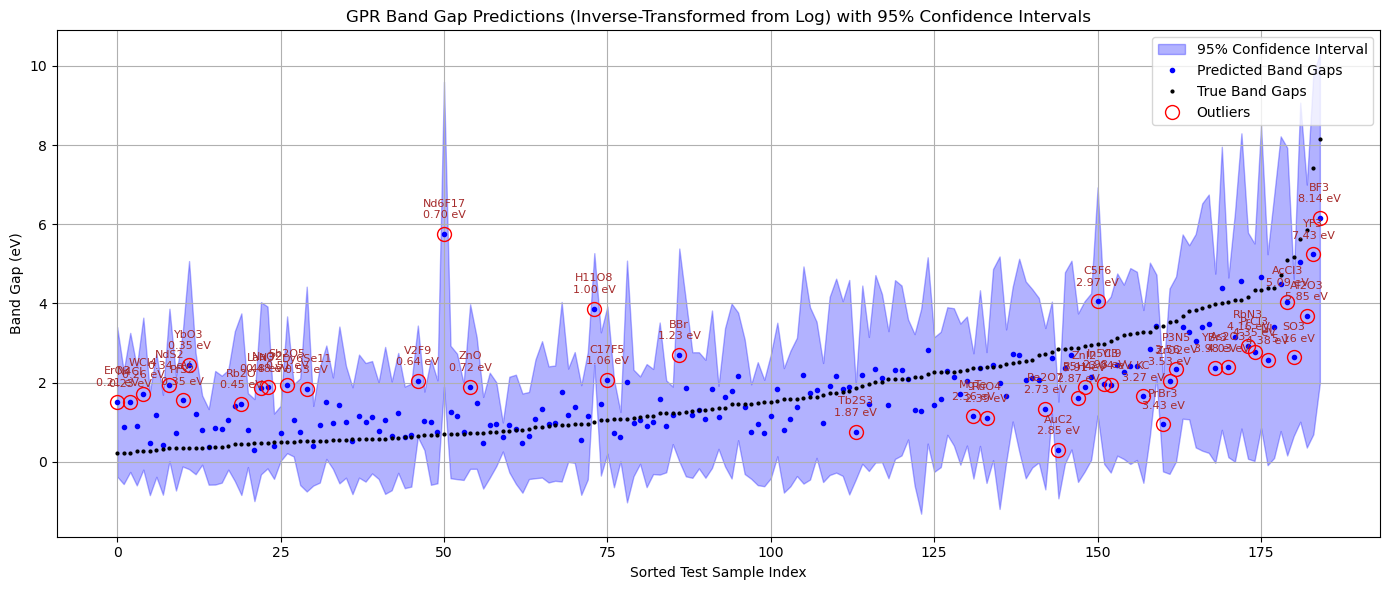

In [51]:
# After predicting in log space, inverse-transform to original band gap scale and plot
# Inverse-transform log-predicted and true values
y_true = np.expm1(y_test_log)
y_pred = np.expm1(y_pred_log)
y_std = np.expm1(y_pred_log + y_std_log) - y_pred  # Approximate std in original space

# Sort by true band gap values for a clearer plot
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_std_sorted = y_std[sorted_idx]

# 95% confidence interval
lower = y_pred_sorted - 1.96 * y_std_sorted
upper = y_pred_sorted + 1.96 * y_std_sorted

# Optional: get formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='95% Confidence Interval', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=4, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("GPR Band Gap Predictions (Inverse-Transformed from Log) with 95% Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
from sklearn.pipeline           import Pipeline
from sklearn.compose            import TransformedTargetRegressor
from sklearn.preprocessing      import StandardScaler, FunctionTransformer
from sklearn.feature_selection  import SelectKBest, f_regression
from sklearn.gaussian_process   import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (ConstantKernel, RBF, Matern,
                                              RationalQuadratic, WhiteKernel)
import numpy as np


In [53]:
log1p = FunctionTransformer(np.log1p, inverse_func=np.expm1)


In [54]:
n_feat = X_train.shape[1]               # 137 in your data

kernel = (ConstantKernel(1.0, (0.1, 10.0)) *
          (RBF(length_scale=1.0,      length_scale_bounds=(1e-2, 1e3)) +
           Matern(length_scale=1.0,    length_scale_bounds=(1e-2, 1e3), nu=2.5) +
           RationalQuadratic(length_scale=1.0, alpha=1.0,
                             length_scale_bounds=(1e-2, 1e3),
                             alpha_bounds=(1e-4, 1e4)))
          + WhiteKernel(noise_level=1e-4,
                        noise_level_bounds=(1e-9, 1e1)))



In [55]:
gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-5,                 # fixed jitter added to the diagonal
        optimizer="fmin_l_bfgs_b",  # default
        n_restarts_optimizer=8,
        normalize_y=False,
        random_state=42)

pipe = Pipeline([
    ("scale",  StandardScaler()),                 # MUST come first
    ("select", SelectKBest(f_regression, k=60)),  # k is tunable
    ("gpr",    gpr)
])

model = TransformedTargetRegressor(regressor=pipe,
                                   transformer=log1p)  # log ↔ expm1 on y


In [56]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {
    "regressor__select__k":   [40, 60, 90],   # try a few
    "regressor__gpr__alpha":  [1e-6, 1e-5]    # bigger α = safer numerically
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(model,
                      param_grid   = param_grid,
                      scoring      = "r2",
                      cv           = cv,
                      n_jobs       = -1,
                      verbose      = 1)
search.fit(X_train, y_train)

print("CV-best R² :", search.best_score_)
print("Params     :", search.best_params_)
print("Kernel     :", search.best_estimator_.regressor_["gpr"].kernel_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/april-ai/anaconda3/lib/python3.11/site-pac

CV-best R² : 0.6774867346982034
Params     : {'regressor__gpr__alpha': 1e-06, 'regressor__select__k': 90}
Kernel     : 0.749**2 * RBF(length_scale=15.6) + Matern(length_scale=33.8, nu=2.5) + RationalQuadratic(alpha=0.0249, length_scale=0.807) + WhiteKernel(noise_level=6.59e-09)


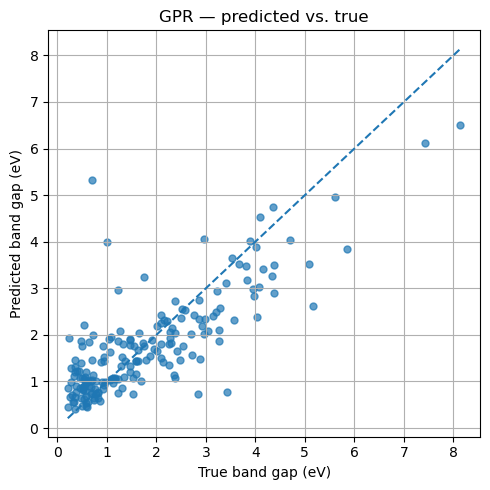

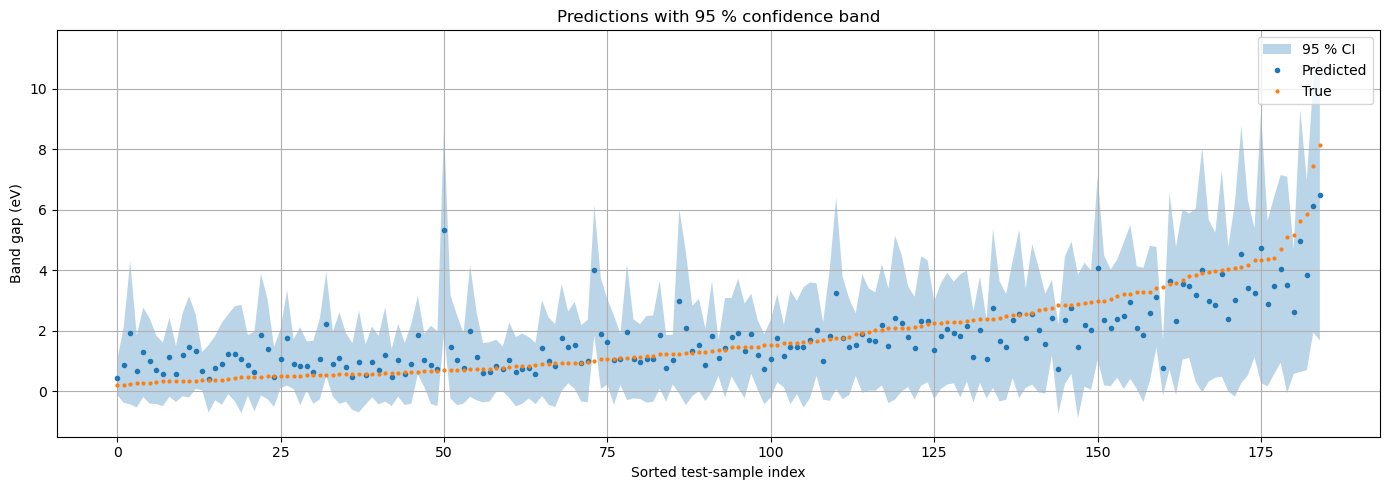

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1 ▸ grab the best fitted model ────────────────────────────────────────────
best_model   = search.best_estimator_          # TransformedTargetRegressor
reg_pipeline = best_model.regressor_           # the X-pipeline + DynamicGPR

# ── 2 ▸ quick helper to invert log targets ────────────────────────────────────
def inv(x): return np.expm1(x)

# ── 3 ▸ scatter: predicted vs true ────────────────────────────────────────────
y_pred_lin = inv(reg_pipeline.predict(X_test))        # μ in eV
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_test, y_pred_lin, s=25, alpha=0.7)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()], linestyle="--")
ax.set_xlabel("True band gap (eV)")
ax.set_ylabel("Predicted band gap (eV)")
ax.set_title("GPR — predicted vs. true")
ax.grid(True)
plt.tight_layout()
plt.show()

# ── 4 ▸ sorted curve with 95 % CI ─────────────────────────────────────────────
y_pred_log, y_std_log = reg_pipeline.predict(X_test, return_std=True)
y_true_log            = log1p.transform(y_test.reshape(-1, 1)).ravel()

y_true = inv(y_true_log)
y_pred = inv(y_pred_log)
y_std  = inv(y_pred_log + y_std_log) - y_pred    # ≈ σ in eV

idx          = np.argsort(y_true)
y_true_s     = y_true[idx]
y_pred_s     = y_pred[idx]
y_std_s      = y_std[idx]

lower = y_pred_s - 1.96 * y_std_s
upper = y_pred_s + 1.96 * y_std_s

fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(np.arange(len(y_true_s)), lower, upper, alpha=0.30,
                label="95 % CI")
ax.plot(y_pred_s, "o", ms=3, label="Predicted")
ax.plot(y_true_s, ".", ms=4, label="True")
ax.set_xlabel("Sorted test-sample index")
ax.set_ylabel("Band gap (eV)")
ax.set_title("Predictions with 95 % confidence band")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
